In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210527.csv')
date = '5/27/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = bath_df.iat[0, 0]
file = path_name + file_name

ftir_min_index = 113
ftir_max_index = 665
ftir_length = ftir_max_index - ftir_min_index

vis_min_index = 0
vis_max_index = 407
vis_length = vis_max_index - vis_min_index

all_absorbances = []
all_depths = []
df = pd.DataFrame()

for index in bath_df.index.values:
    session = bath_df['session'][index]
    calibration = bath_df['calibration'][index]
    insertion = bath_df['insertion'][index]
    i_unique = bath_df['i_unique'][index]
    stop = bath_df['conditions'][index][-2:]
    cal_path = f'{session}/{calibration}'
    insertion_path = f'{session}/{calibration}/{insertion}'
    vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
    vis_columns = ["%.1f" % wave for wave in vis_waves]
    insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
    
    ftir_waves = get_ftir_wavelength_vector(file, cal_path)[ftir_min_index:ftir_max_index]
    
    ftir_columns = ["%.1f" % wave for wave in ftir_waves]
    ftir_insertion_df = pd.DataFrame(get_ftir_insertion_absorbances(file, insertion_path)[:, ftir_min_index:ftir_max_index], columns=ftir_columns)
    
    insertion_df = pd.concat([insertion_df, ftir_insertion_df], axis=1)
    insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
    insertion_df['session'] = session
    insertion_df['calibration'] = calibration
    insertion_df['insertion'] = insertion
    insertion_df['i_unique'] = i_unique
    insertion_df['stop'] = stop
    insertion_df['use'] = True
    df = pd.concat([df, insertion_df], ignore_index=True)
    
df.loc[(df.depth < 4.0),'use'] = False
df.loc[(df['1203.8'] > 0.65), 'use'] = False
df.loc[(df['1203.8'] < 0.20), 'use'] = False
df.loc[(df['1400.3'] > 0.65), 'use'] = False
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False
df.loc[(df['1951.1'] < df['2002.5']), 'use'] = False
    
print(df.shape)


(501, 966)


In [5]:
df['use']
df.loc[df['use']].shape

(425, 966)

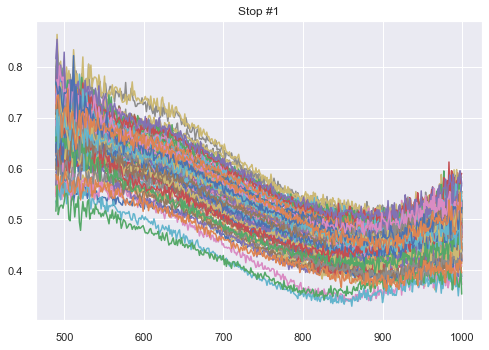

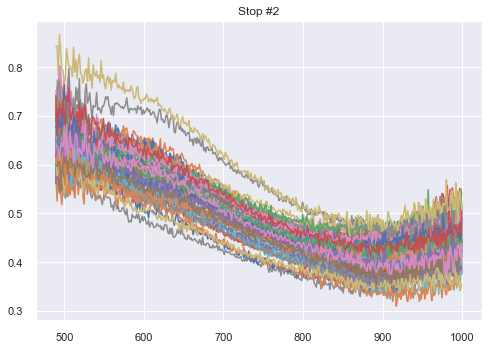

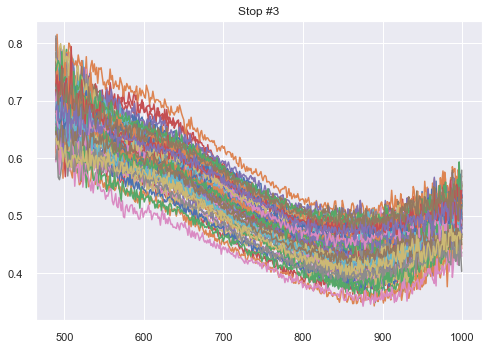

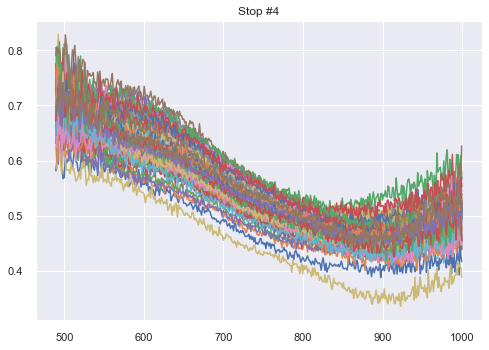

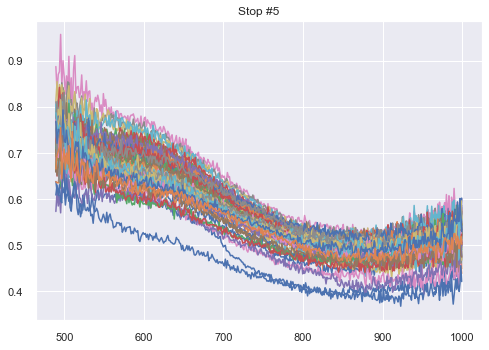

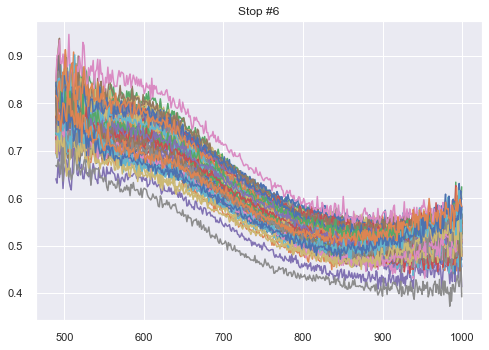

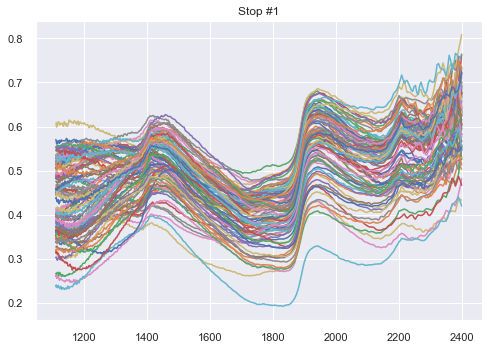

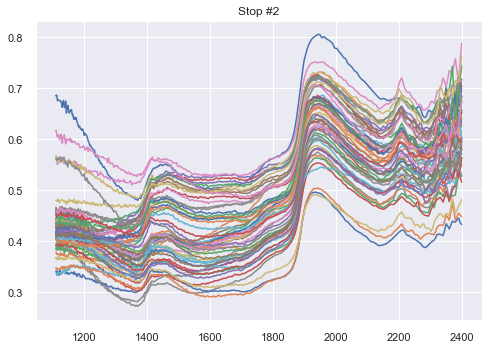

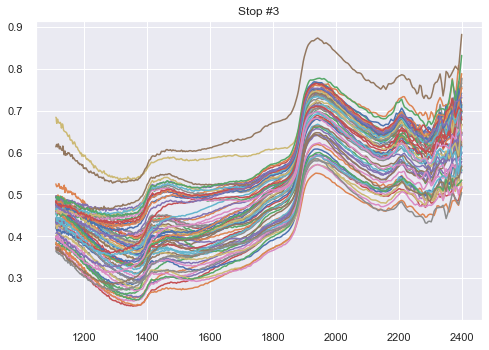

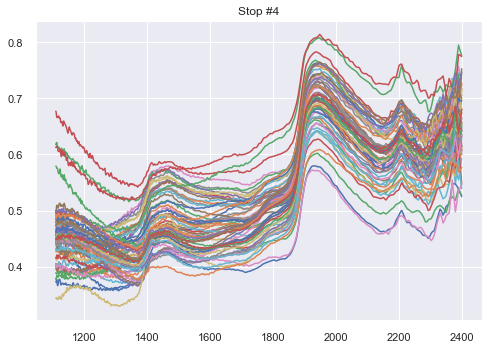

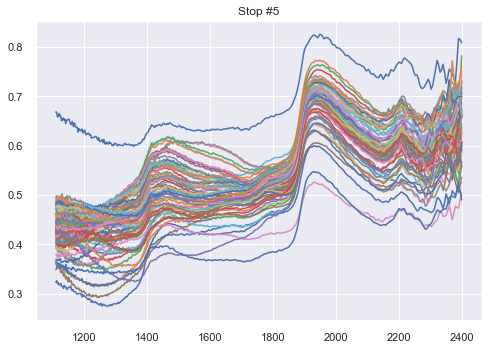

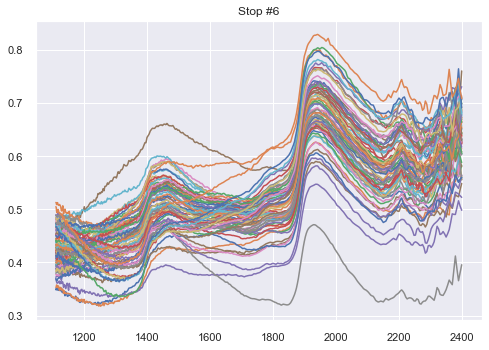

In [6]:
df_use = df.loc[df['use']].copy()
for stop in df_use['stop'].unique():
    stop_df = df_use.loc[df_use['stop'] == stop]
    
    
    fig, ax = plt.subplots()
    ax.set_title(f"Stop {stop}")
    for i in range(stop_df.shape[0]):
        ax.plot(vis_waves, stop_df.iloc[i, :vis_max_index])
    plt.show()
    plt.close()
    
for stop in df_use['stop'].unique():
    stop_df = df_use.loc[df_use['stop'] == stop]
    
    
    fig, ax = plt.subplots()
    ax.set_title(f"Stop {stop}")
    for i in range(stop_df.shape[0]):
        ax.plot(ftir_waves, stop_df.iloc[i, vis_max_index:(ftir_length + vis_max_index)])
    plt.show()
    plt.close()
    
        

In [7]:
print(vis_columns)

['489.3', '490.8', '492.3', '493.8', '495.3', '496.8', '498.3', '499.8', '501.3', '502.7', '504.2', '505.7', '507.2', '508.6', '510.1', '511.6', '513.0', '514.5', '516.0', '517.4', '518.9', '520.3', '521.8', '523.2', '524.7', '526.1', '527.6', '529.0', '530.5', '531.9', '533.4', '534.8', '536.2', '537.7', '539.1', '540.5', '541.9', '543.4', '544.8', '546.2', '547.6', '549.0', '550.5', '551.9', '553.3', '554.7', '556.1', '557.5', '558.9', '560.3', '561.7', '563.1', '564.5', '565.9', '567.3', '568.7', '570.1', '571.5', '572.9', '574.3', '575.7', '577.0', '578.4', '579.8', '581.2', '582.6', '584.0', '585.3', '586.7', '588.1', '589.5', '590.8', '592.2', '593.6', '594.9', '596.3', '597.7', '599.0', '600.4', '601.8', '603.1', '604.5', '605.8', '607.2', '608.6', '609.9', '611.3', '612.6', '614.0', '615.3', '616.7', '618.0', '619.4', '620.7', '622.1', '623.4', '624.7', '626.1', '627.4', '628.8', '630.1', '631.5', '632.8', '634.1', '635.5', '636.8', '638.1', '639.5', '640.8', '642.1', '643.5', 

In [8]:
print(ftir_columns)

['1111.2', '1112.3', '1113.3', '1114.4', '1115.5', '1116.6', '1117.7', '1118.8', '1119.9', '1121.0', '1122.1', '1123.2', '1124.3', '1125.4', '1126.5', '1127.6', '1128.8', '1129.9', '1131.0', '1132.1', '1133.2', '1134.4', '1135.5', '1136.6', '1137.8', '1138.9', '1140.0', '1141.2', '1142.3', '1143.5', '1144.6', '1145.8', '1146.9', '1148.1', '1149.2', '1150.4', '1151.5', '1152.7', '1153.9', '1155.0', '1156.2', '1157.4', '1158.6', '1159.7', '1160.9', '1162.1', '1163.3', '1164.5', '1165.7', '1166.9', '1168.1', '1169.3', '1170.5', '1171.7', '1172.9', '1174.1', '1175.3', '1176.5', '1177.7', '1178.9', '1180.1', '1181.4', '1182.6', '1183.8', '1185.0', '1186.3', '1187.5', '1188.7', '1190.0', '1191.2', '1192.5', '1193.7', '1195.0', '1196.2', '1197.5', '1198.7', '1200.0', '1201.3', '1202.5', '1203.8', '1205.1', '1206.3', '1207.6', '1208.9', '1210.2', '1211.5', '1212.8', '1214.0', '1215.3', '1216.6', '1217.9', '1219.2', '1220.5', '1221.8', '1223.2', '1224.5', '1225.8', '1227.1', '1228.4', '1229.7',

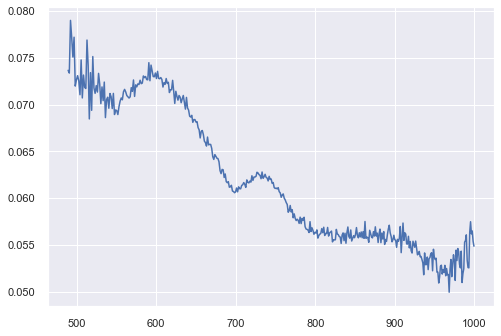

In [9]:
plt.plot(vis_waves, df.loc[:, '489.3':'999.6'].std())

In [10]:
all_waves = np.append([vis_waves], [ftir_waves])

In [11]:
all_waves

array([ 489.31041707,  490.8120618 ,  492.31117119,  493.80776961,
        495.30188125,  496.79353007,  498.28273984,  499.76953412,
        501.25393625,  502.73596939,  504.21565648,  505.69302026,
        507.16808328,  508.64086787,  510.11139617,  511.57969013,
        513.04577148,  514.50966177,  515.97138235,  517.43095436,
        518.88839877,  520.34373633,  521.79698761,  523.24817298,
        524.69731263,  526.14442654,  527.58953453,  529.03265618,
        530.47381093,  531.91301802,  533.35029647,  534.78566516,
        536.21914276,  537.65074774,  539.08049843,  540.50841293,
        541.93450918,  543.35880494,  544.78131778,  546.2020651 ,
        547.6210641 ,  549.03833184,  550.45388515,  551.86774073,
        553.27991508,  554.69042452,  556.09928522,  557.50651314,
        558.91212409,  560.31613372,  561.71855748,  563.11941067,
        564.5187084 ,  565.91646563,  567.31269714,  568.70741756,
        570.10064132,  571.49238271,  572.88265586,  574.27147

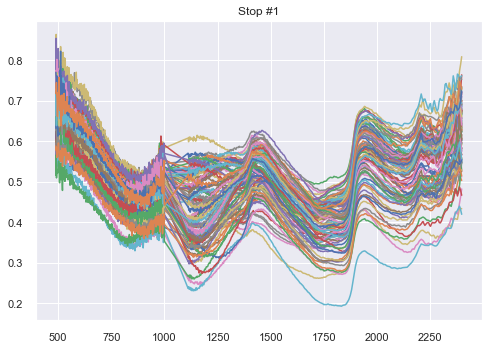

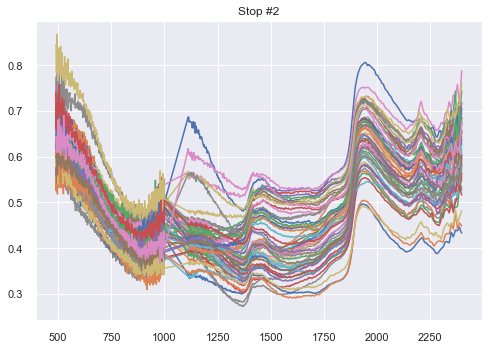

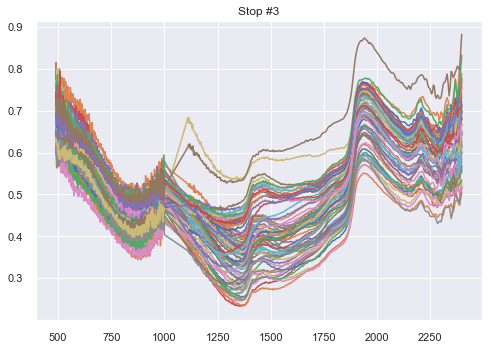

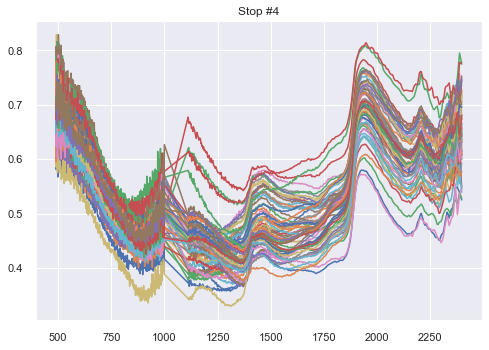

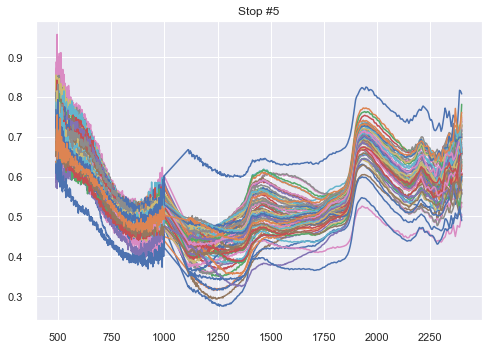

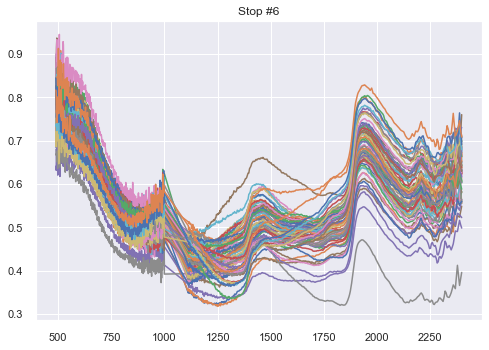

In [12]:
df_use = df.loc[df['use']].copy()
for stop in df_use['stop'].unique():
    stop_df = df_use.loc[df_use['stop'] == stop]
    
    
    fig, ax = plt.subplots()
    ax.set_title(f"Stop {stop}")
    for i in range(stop_df.shape[0]):
        ax.plot(all_waves, stop_df.iloc[i, :(vis_length + ftir_length)])
    plt.show()
    plt.close()
    


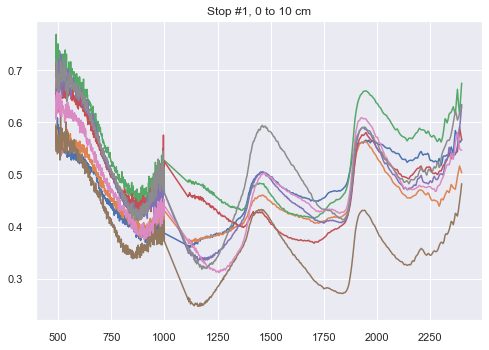

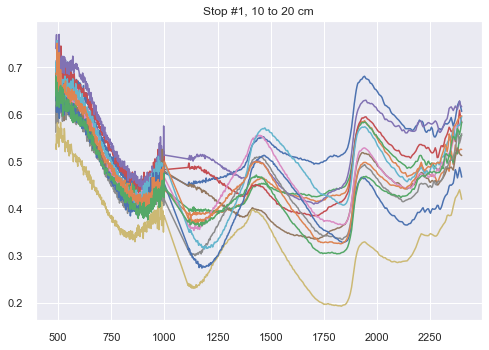

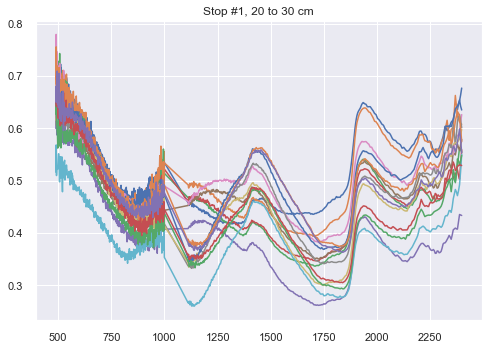

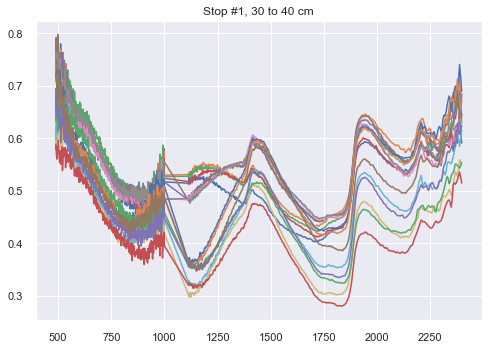

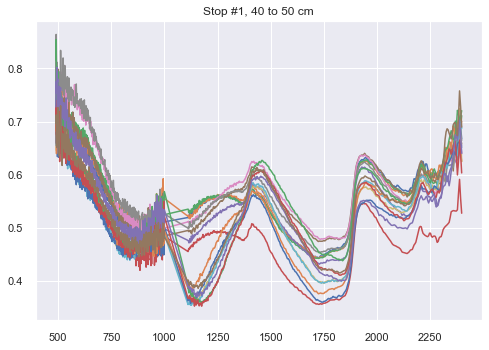

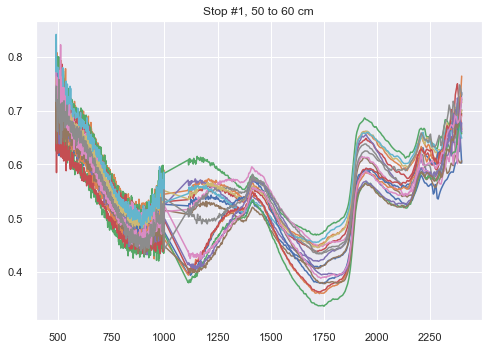

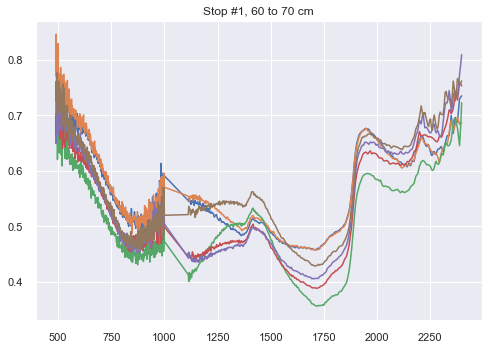

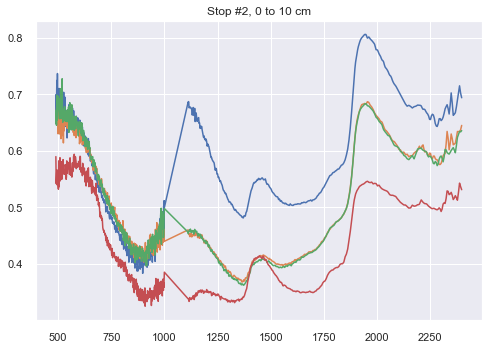

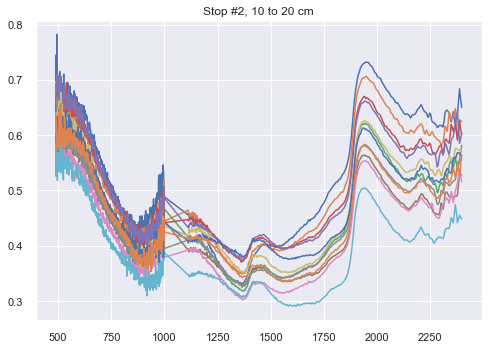

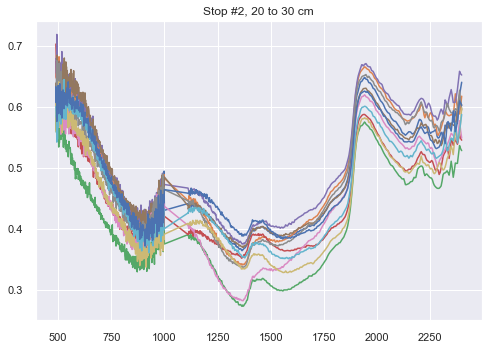

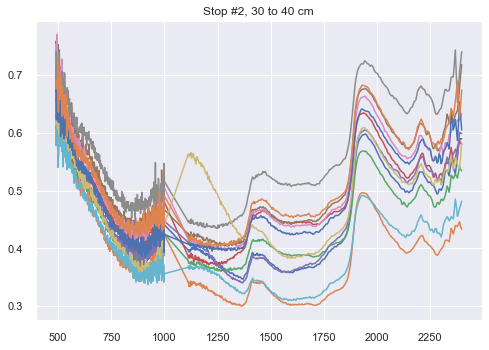

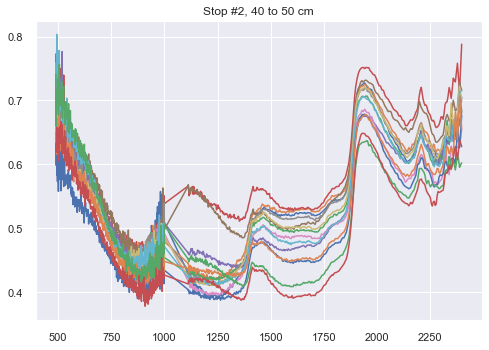

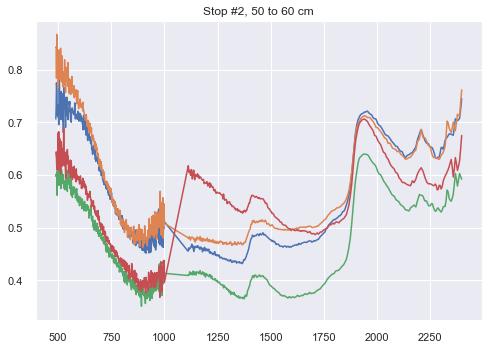

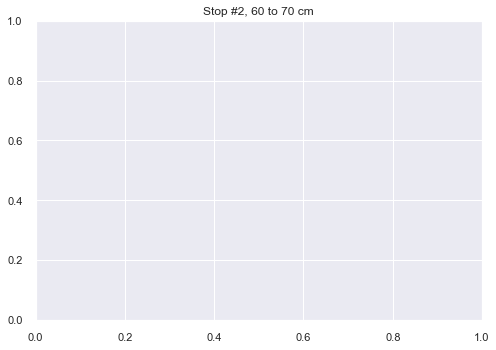

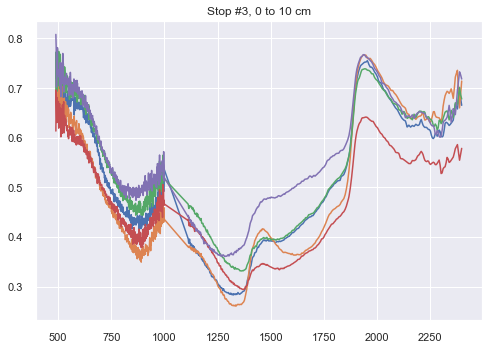

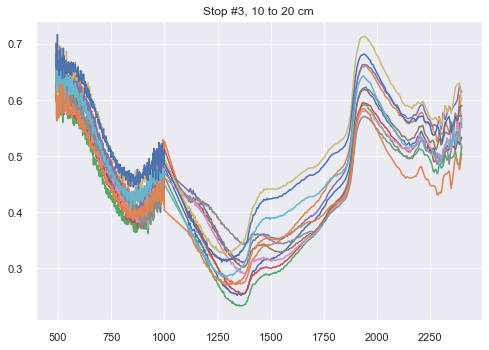

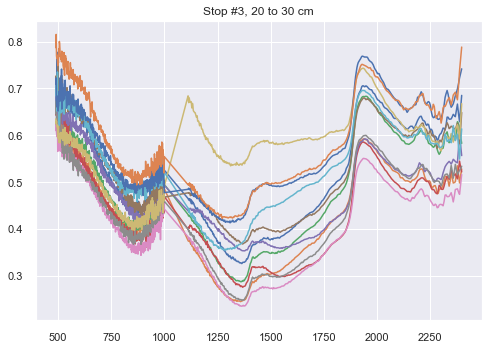

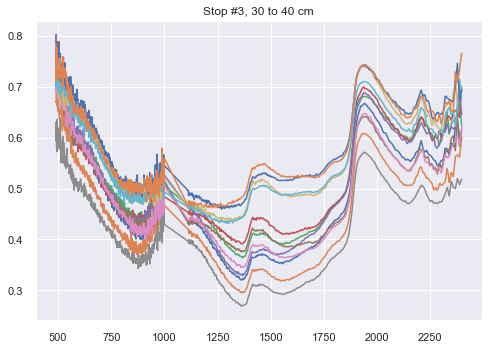

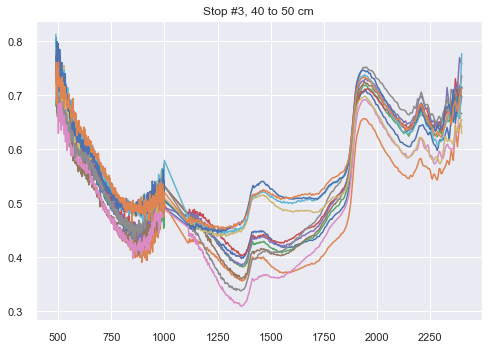

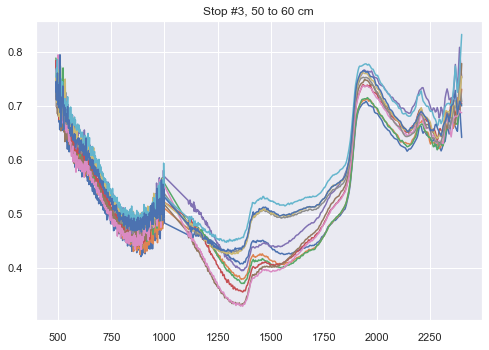

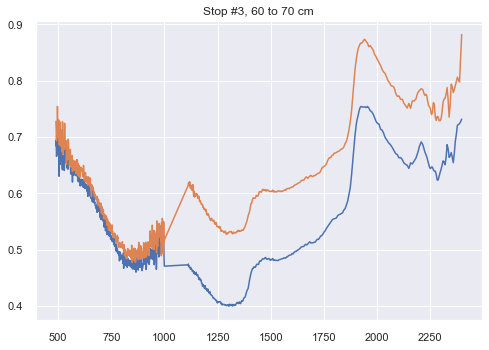

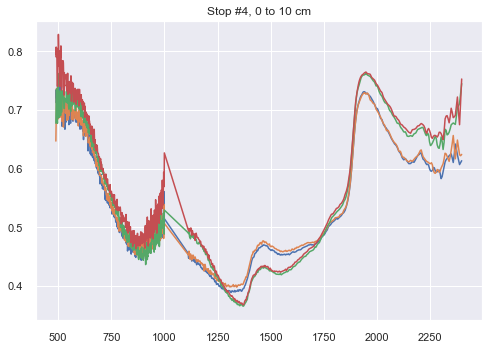

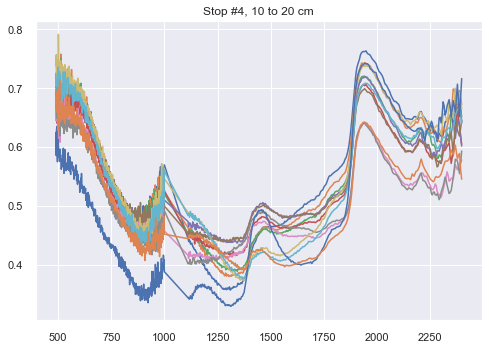

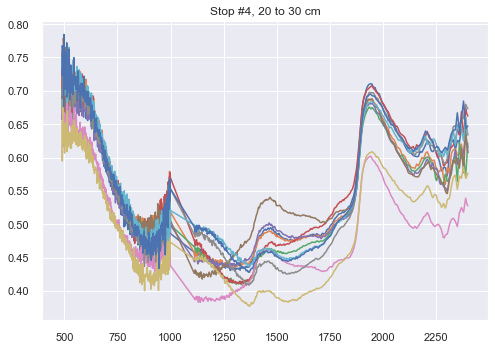

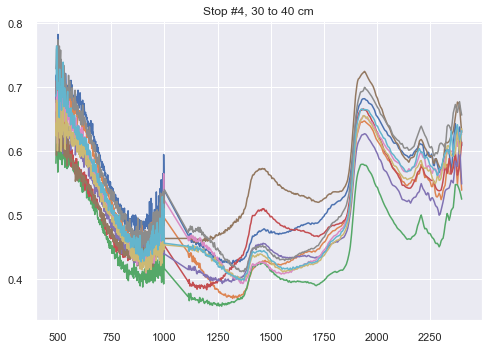

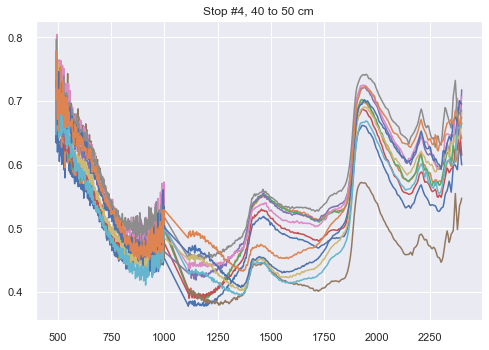

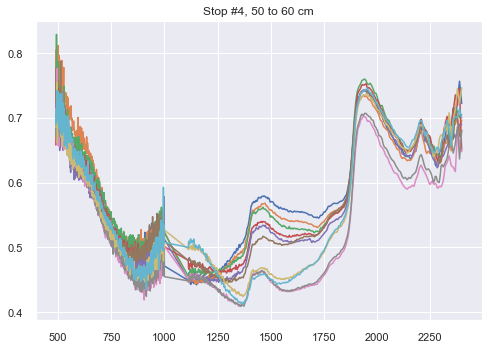

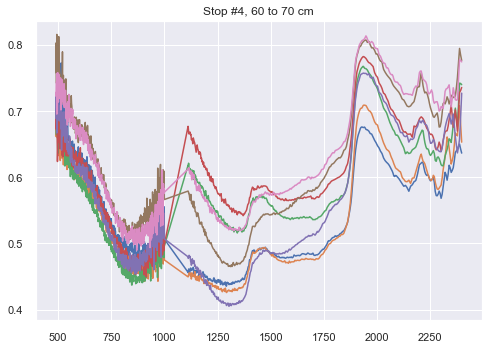

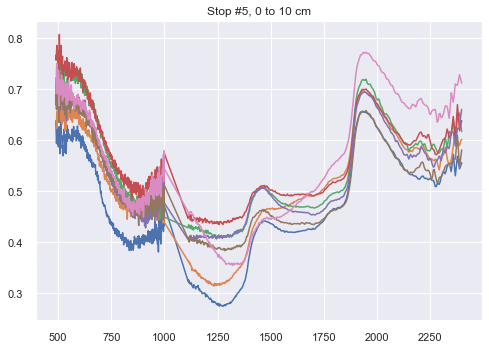

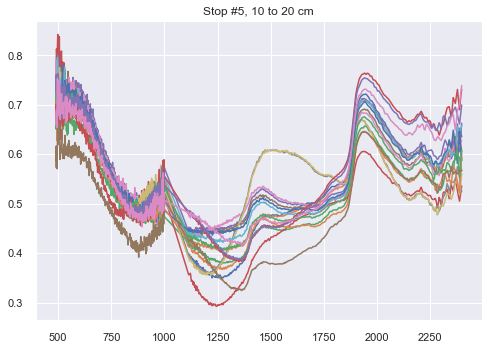

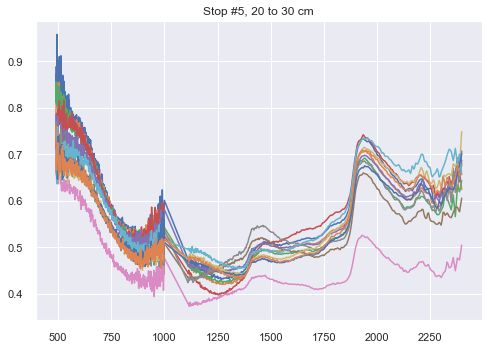

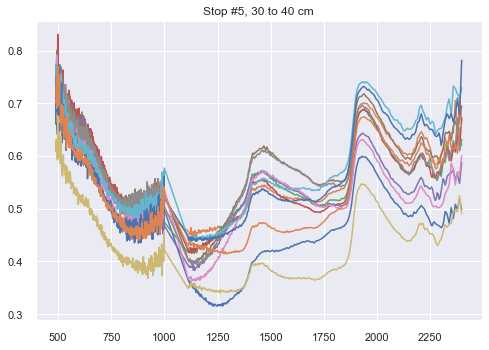

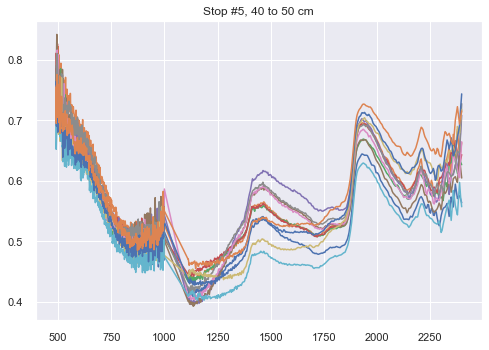

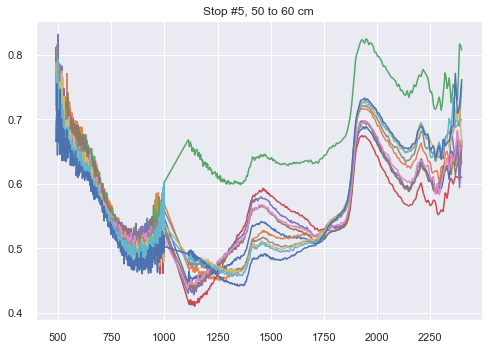

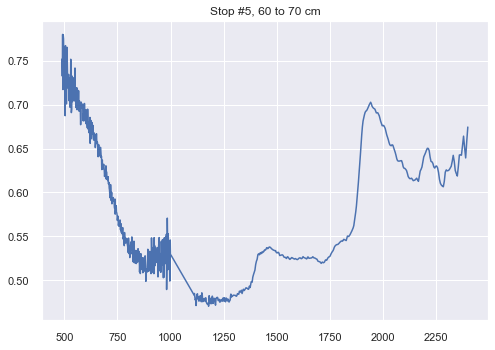

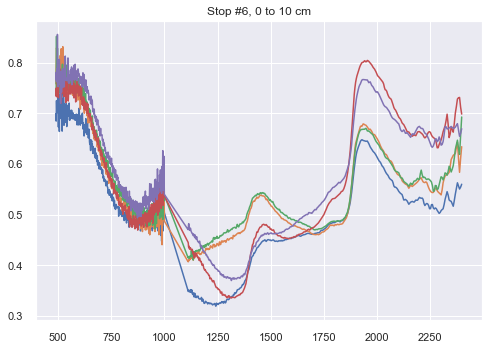

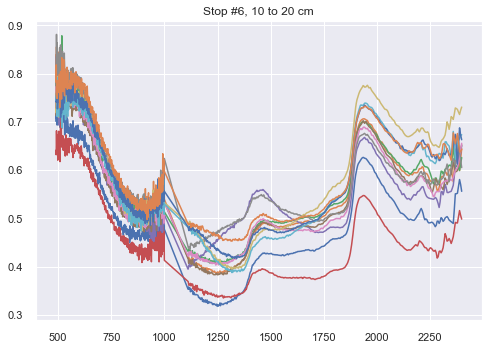

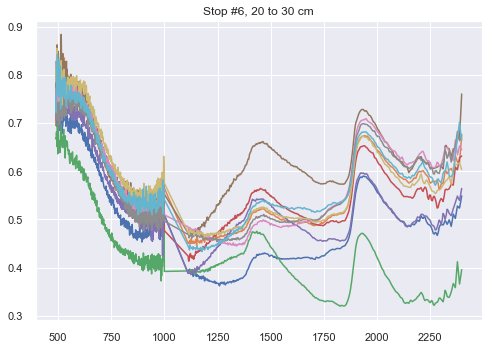

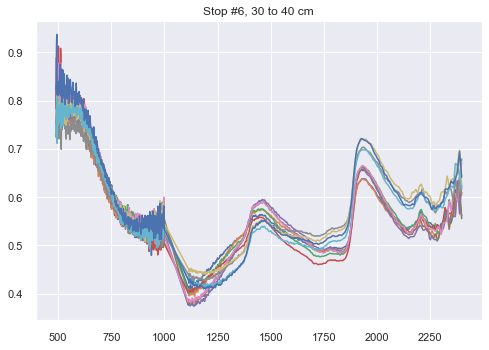

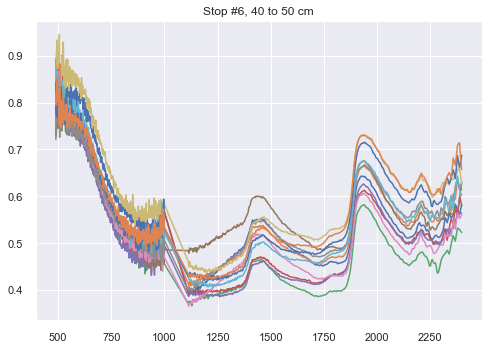

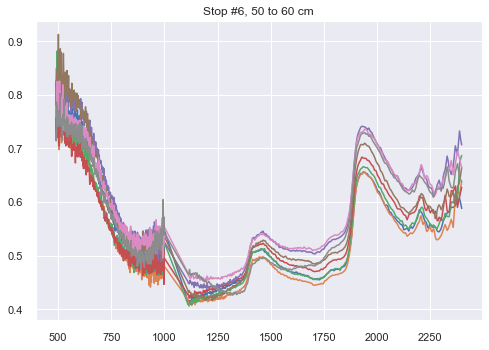

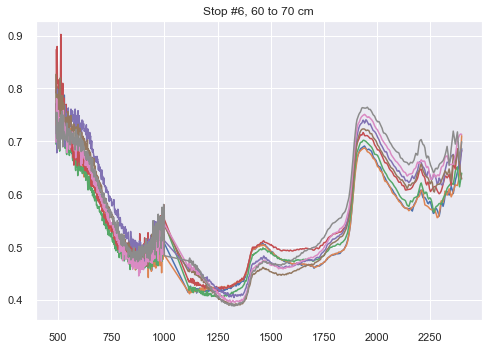

In [13]:
df_use = df.loc[df['use']].copy()
for stop in df_use['stop'].unique():
    stop_df = df_use.loc[df_use['stop'] == stop]
    for depth in range(0, 61, 10):
        depth_min = depth
        depth_max = depth + 10
        depth_df = stop_df.loc[(stop_df['depth'] >= depth_min) & (stop_df['depth'] < depth_max)]       
        


        fig, ax = plt.subplots()
        ax.set_title(f"Stop {stop}, {depth_min} to {depth_max} cm")
        for i in range(depth_df.shape[0]):
            ax.plot(all_waves, depth_df.iloc[i, :(vis_length + ftir_length)])
        plt.show()
        plt.close()

In [14]:
vis_waves[407]

IndexError: index 407 is out of bounds for axis 0 with size 407